# If you want to change, make a copy of this file and edit that copy.

# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# load dataset

expression_data = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
methylation_data = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
copy_number_data = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)
subtype_encoded = pd.read_csv("../NewDatasets/subtype_encoded_FXS_MOFA_3Omics.csv", index_col=0)
expression_data_scaled = pd.DataFrame(StandardScaler().fit_transform(expression_data), index=expression_data.index, columns=expression_data.columns)
methylation_scaled = pd.DataFrame(StandardScaler().fit_transform(methylation_data), index=methylation_data.index, columns=methylation_data.columns)
copy_number_scaled = pd.DataFrame(StandardScaler().fit_transform(copy_number_data), index=copy_number_data.index, columns=copy_number_data.columns)

In [18]:
subtype_encoded = pd.read_csv("../NewDatasets/subtype_encoded_FXS_MOFA_3Omics.csv", index_col=0)
common_samples = expression_data_scaled.index.intersection(
    methylation_scaled.index
).intersection(copy_number_scaled.index).intersection(subtype_encoded.index)

In [29]:
from mofapy2.run.entry_point import entry_point
import cupy as cp
try:
    cp._default_memory_pool.free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
except:
    pass
data_list = [
    [expression_data_scaled.values],   # view 0, group 0
    [methylation_scaled.values],       # view 1, group 0
    [copy_number_scaled.values]       # view 2, group 0
]

# Initialise MOFA
ent = entry_point()
ent.set_data_options(
    scale_views=True,
    scale_groups=False
)
ent.set_data_matrix(data_list)

ent.set_model_options(
    factors=20,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=100,
    convergence_mode="medium",
    seed=42,
    verbose=True,
    gpu_mode=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_gr

In [30]:
print("Factors shape",factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)
print("Weights shape (view2):", weights[2].shape)


Factors shape (205, 20)
Weights shape (view0): (44663, 20)
Weights shape (view1): (419542, 20)
Weights shape (view2): (56756, 20)


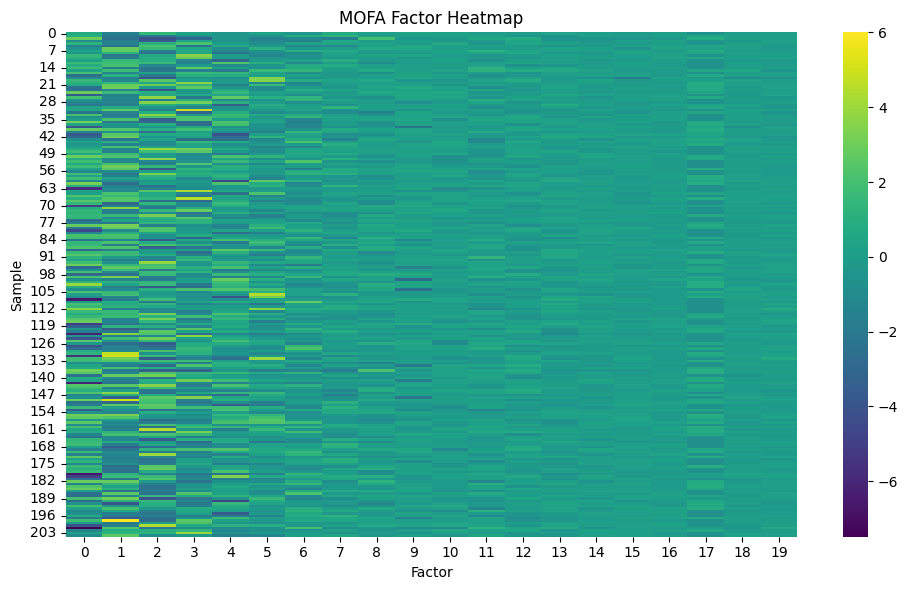

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


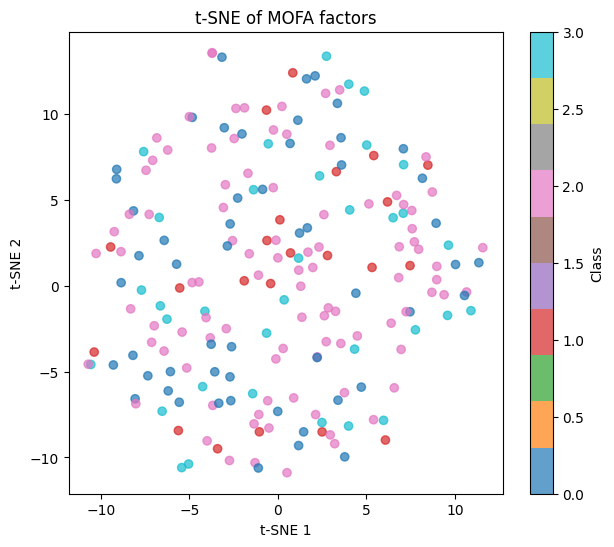

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()


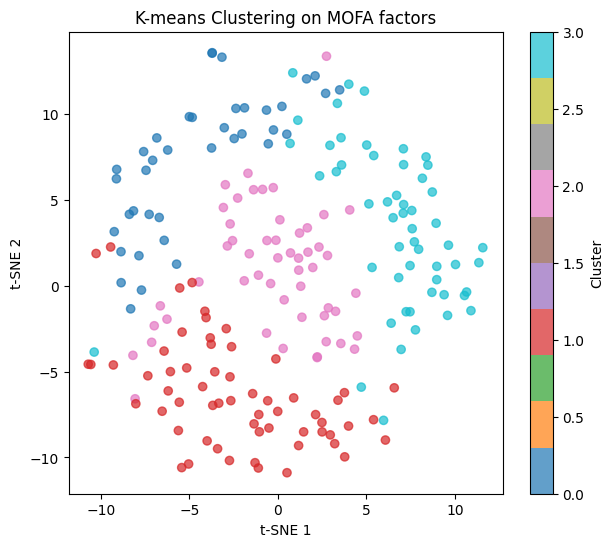

In [33]:
#kmeans clustering on the factors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(factors)
labels = kmeans.labels_
plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K-means Clustering on MOFA factors")
plt.colorbar(label="Cluster")
plt.show()

In [34]:
import numpy as np

# Get factor matrix (samples × factors)
factors = ent.model.nodes["Z"].getExpectation()

# Compute L2 norm of each factor across samples
factor_norms = np.linalg.norm(factors, axis=0)

print("Factor norms:", factor_norms)
active_factors = np.sum(factor_norms > 1e-2)  # threshold can be adjusted
print(f"Active factors: {active_factors} / {factors.shape[1]}")


Factor norms: [32.59311736 29.19133405 29.48717695 23.96250331 20.87124214 16.13816154
 12.86315398  8.87695159  7.84892028  7.94704975  4.93433583  7.14736655
  5.88167438  5.03040728  3.31291682  3.23806032  2.16443691  9.52374684
  2.37084654  2.85111697]
Active factors: 20 / 20


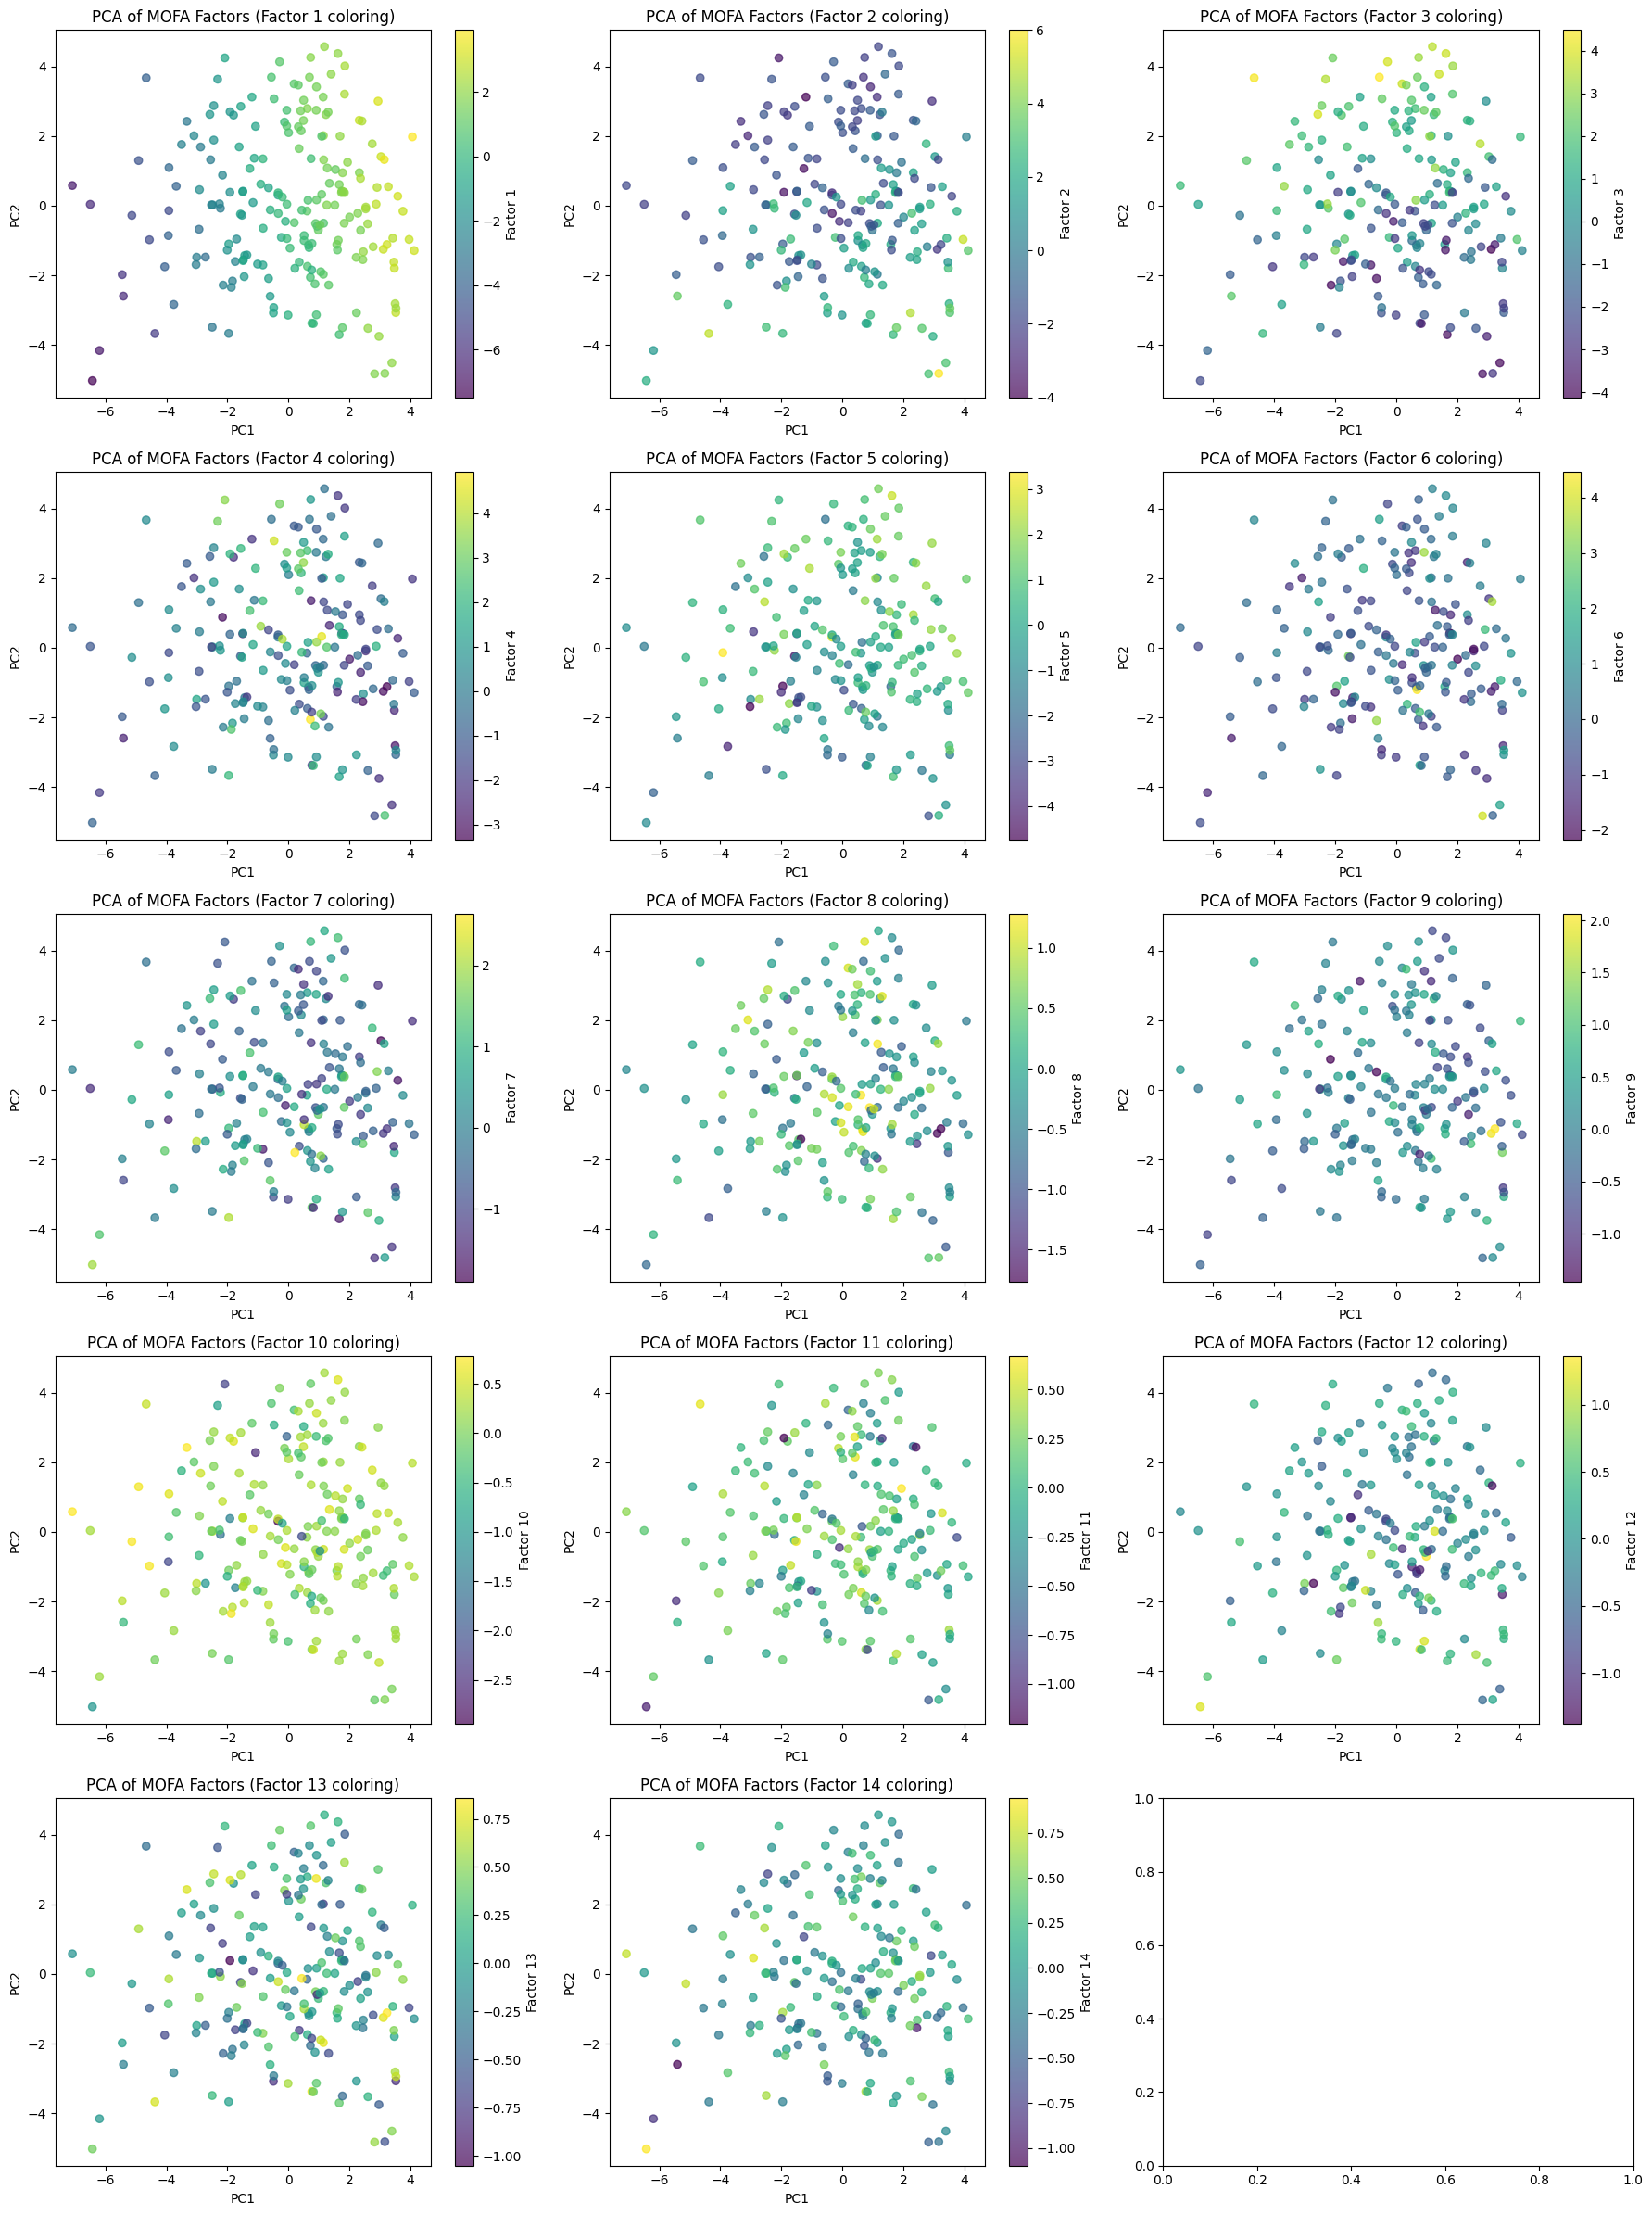

In [35]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
# labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(14):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Factors: samples × factors
X = np.array(factors)   # shape (177, 20)

# Labels: subtype-encoded
y = subtype_encoded.loc[common_samples].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

# Predictions and accuracy
preds_lr = clf_lr.predict(X_test)
y_true_lr = y_test
acc_lr = accuracy_score(y_true_lr, preds_lr)
y_pred_proba_lr = clf_lr.predict_proba(X_test)
print('Logistic Regression accuracy:', acc_lr)

Logistic Regression accuracy: 0.5365853658536586


In [37]:
# 2. Random Forest on MOFA factors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict(X_test)
y_true_rf = y_test
acc_rf = accuracy_score(y_true_rf, preds_rf)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
print('Random Forest accuracy:', acc_rf)

Random Forest accuracy: 0.6341463414634146


In [38]:
# 3. Support Vector Machine (SVM) on MOFA factors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm = clf_svm.predict(X_test)
y_true_svm = y_test
acc_svm = accuracy_score(y_true_svm, preds_svm)
y_pred_proba_svm = clf_svm.predict_proba(X_test)
print('SVM accuracy:', acc_svm)

SVM accuracy: 0.36585365853658536


In [39]:
# 4. K-Nearest Neighbors (KNN) on MOFA factors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)
preds_knn = clf_knn.predict(X_test)
y_true_knn = y_test
acc_knn = accuracy_score(y_true_knn, preds_knn)
y_pred_proba_knn = clf_knn.predict_proba(X_test)
print('KNN accuracy:', acc_knn)

KNN accuracy: 0.24390243902439024


In [40]:
# 5. Gradient Boosting (XGBoost) on MOFA factors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
try:
    from xgboost import XGBClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    clf_xgb.fit(X_train, y_train)
    preds_xgb = clf_xgb.predict(X_test)
    y_true_xgb = y_test
    acc_xgb = accuracy_score(y_true_xgb, preds_xgb)
    y_pred_proba_xgb = clf_xgb.predict_proba(X_test)
    print('XGBoost accuracy:', acc_xgb)
except ImportError:
    print('XGBoost is not installed. Please install xgboost to use this model.')

XGBoost accuracy: 0.5853658536585366


In [41]:
# 6. Naive Bayes on MOFA factors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
preds_nb = clf_nb.predict(X_test)
y_true_nb = y_test
acc_nb = accuracy_score(y_true_nb, preds_nb)
y_pred_proba_nb = clf_nb.predict_proba(X_test)
print('Naive Bayes accuracy:', acc_nb)

Naive Bayes accuracy: 0.4878048780487805


In [42]:
# Compare all 6 classifiers on MOFA factors: accuracy, F1 (macro/micro), precision, recall, C-index
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import column_or_1d
import numpy as np
import pandas as pd

# Function to calculate C-index (concordance index)
def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (concordance index) for multiclass classification
    """
    try:
        from sklearn.metrics import roc_auc_score
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

results = []
results.append(["Logistic Regression", acc_lr, f1_score(y_true_lr, preds_lr, average='macro'), f1_score(y_true_lr, preds_lr, average='micro'), precision_score(y_true_lr, preds_lr, average='macro', zero_division=0), precision_score(y_true_lr, preds_lr, average='micro', zero_division=0), recall_score(y_true_lr, preds_lr, average='macro'), recall_score(y_true_lr, preds_lr, average='micro'), concordance_index(y_true_lr, y_pred_proba_lr)])
results.append(["Random Forest", acc_rf, f1_score(y_true_rf, preds_rf, average='macro'), f1_score(y_true_rf, preds_rf, average='micro'), precision_score(y_true_rf, preds_rf, average='macro', zero_division=0), precision_score(y_true_rf, preds_rf, average='micro', zero_division=0), recall_score(y_true_rf, preds_rf, average='macro'), recall_score(y_true_rf, preds_rf, average='micro'), concordance_index(y_true_rf, y_pred_proba_rf)])
results.append(["SVM", acc_svm, f1_score(y_true_svm, preds_svm, average='macro'), f1_score(y_true_svm, preds_svm, average='micro'), precision_score(y_true_svm, preds_svm, average='macro', zero_division=0), precision_score(y_true_svm, preds_svm, average='micro', zero_division=0), recall_score(y_true_svm, preds_svm, average='macro'), recall_score(y_true_svm, preds_svm, average='micro'), concordance_index(y_true_svm, y_pred_proba_svm)])
results.append(["KNN", acc_knn, f1_score(y_true_knn, preds_knn, average='macro'), f1_score(y_true_knn, preds_knn, average='micro'), precision_score(y_true_knn, preds_knn, average='macro', zero_division=0), precision_score(y_true_knn, preds_knn, average='micro', zero_division=0), recall_score(y_true_knn, preds_knn, average='macro'), recall_score(y_true_knn, preds_knn, average='micro'), concordance_index(y_true_knn, y_pred_proba_knn)])
try:
    results.append(["XGBoost", acc_xgb, f1_score(y_true_xgb, preds_xgb, average='macro'), f1_score(y_true_xgb, preds_xgb, average='micro'), precision_score(y_true_xgb, preds_xgb, average='macro', zero_division=0), precision_score(y_true_xgb, preds_xgb, average='micro', zero_division=0), recall_score(y_true_xgb, preds_xgb, average='macro'), recall_score(y_true_xgb, preds_xgb, average='micro'), concordance_index(y_true_xgb, y_pred_proba_xgb)])
except:
    pass
results.append(["Naive Bayes", acc_nb, f1_score(y_true_nb, preds_nb, average='macro'), f1_score(y_true_nb, preds_nb, average='micro'), precision_score(y_true_nb, preds_nb, average='macro', zero_division=0), precision_score(y_true_nb, preds_nb, average='micro', zero_division=0), recall_score(y_true_nb, preds_nb, average='macro'), recall_score(y_true_nb, preds_nb, average='micro'), concordance_index(y_true_nb, y_pred_proba_nb)])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Macro", "F1 Micro", "Precision Macro", "Precision Micro", "Recall Macro", "Recall Micro", "C-Index"])
print(results_df.round(3))

                 Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Logistic Regression     0.537     0.341     0.537            0.388   
1        Random Forest     0.634     0.414     0.634            0.407   
2                  SVM     0.366     0.228     0.366            0.278   
3                  KNN     0.244     0.139     0.244            0.124   
4              XGBoost     0.585     0.418     0.585            0.454   
5          Naive Bayes     0.488     0.306     0.488            0.301   

   Precision Micro  Recall Macro  Recall Micro  C-Index  
0            0.537         0.360         0.537    0.678  
1            0.634         0.451         0.634    0.775  
2            0.366         0.239         0.366    0.440  
3            0.244         0.160         0.244    0.415  
4            0.585         0.428         0.585    0.768  
5            0.488         0.311         0.488    0.687  


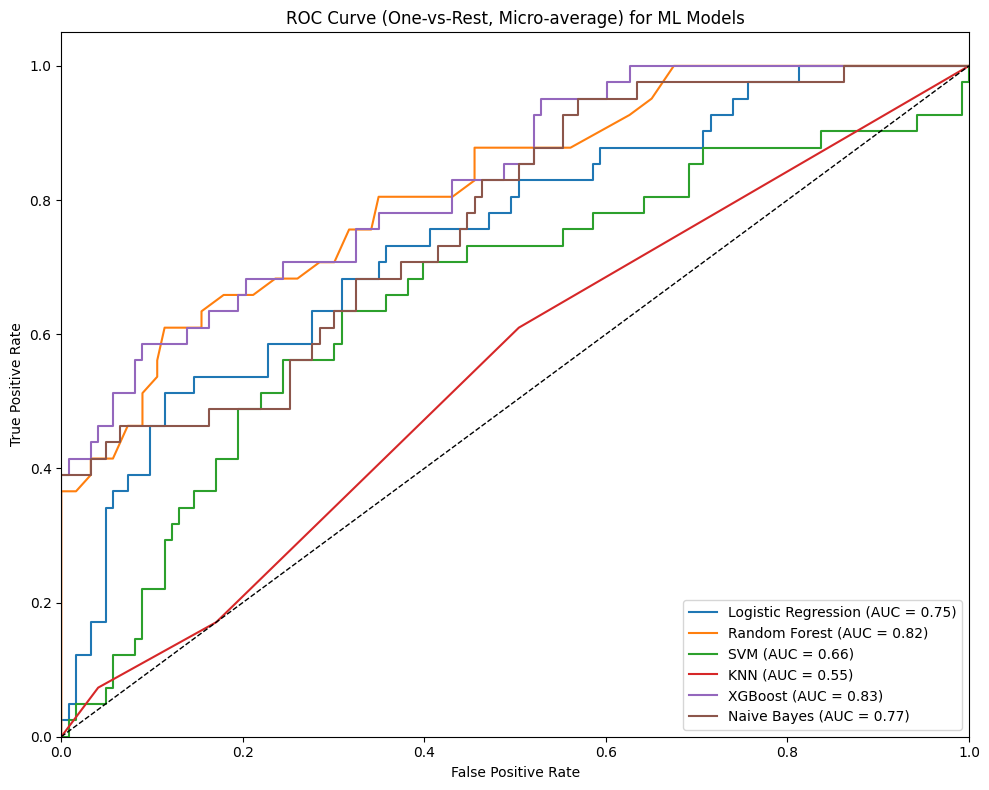

In [43]:
# Plot ROC curves and compute AUC for all ML models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

# List of models and their predicted probabilities
models = [
    ('Logistic Regression', y_pred_proba_lr, y_true_lr),
    ('Random Forest', y_pred_proba_rf, y_true_rf),
    ('SVM', y_pred_proba_svm, y_true_svm),
    ('KNN', y_pred_proba_knn, y_true_knn),
    ('XGBoost', y_pred_proba_xgb, y_true_xgb),
    ('Naive Bayes', y_pred_proba_nb, y_true_nb)
 ]

plt.figure(figsize=(10, 8))
for name, y_pred_proba, y_true in models:
    try:
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for ML Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [44]:
# Prepare data (expects `factors` and `subtype_encoded` to exist from earlier cells)
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values

# Split: train+val / test, then carve out validation from train
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [45]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(np.unique(y))

model = ShallowMLP(input_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping settings
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
batch_size = 16

# Simple batch training without DataLoader to keep the cell compact
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    # --- training ---
    model.train()
    # shuffle
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    # --- validation ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()

    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    # check early stopping (val loss improvement)
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch} (no improvement for {patience} epochs)")
            break

# load best model state (if saved)
if best_state is not None:
    model.load_state_dict(best_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits_shallow = model(X_test_t)
    preds_shallow = logits_shallow.argmax(dim=1).cpu().numpy()
    y_true_shallow = y_test_t.cpu().numpy()

acc_shallow = accuracy_score(y_true_shallow, preds_shallow)
f1_shallow = f1_score(y_true_shallow, preds_shallow, average='macro')
print(f"\nTest Accuracy: {acc_shallow:.4f} | Test F1 (macro): {f1_shallow:.4f}")
# End of shallow MLP cell

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = DeepMLP(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
batch_size = 16
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    model.train()
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    model.eval()
    with torch.no_grad():
        val_out = model(X_val_t)
        val_loss = criterion(val_out, y_val_t).item()

    print(f"[DeepMLP] Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[DeepMLP] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    logits_deep = model(X_test_t)
    preds_deep = logits_deep.argmax(dim=1).cpu().numpy()
    y_true_deep = y_test_t.cpu().numpy()

acc_deep = accuracy_score(y_true_deep, preds_deep)
macrof1_deep = f1_score(y_true_deep, preds_deep, average='macro')
print(f"[DeepMLP] Test Accuracy: {acc_deep:.4f} | Test F1 (macro): {macrof1_deep:.4f}")

[DeepMLP] Epoch 001 | Train loss: 1.3098 | Val loss: 1.1704
[DeepMLP] Epoch 002 | Train loss: 1.1204 | Val loss: 1.0132
[DeepMLP] Epoch 003 | Train loss: 0.9591 | Val loss: 0.8730
[DeepMLP] Epoch 004 | Train loss: 0.8408 | Val loss: 0.7706
[DeepMLP] Epoch 005 | Train loss: 0.7392 | Val loss: 0.7590
[DeepMLP] Epoch 006 | Train loss: 0.6517 | Val loss: 0.7449
[DeepMLP] Epoch 007 | Train loss: 0.5797 | Val loss: 0.7204
[DeepMLP] Epoch 008 | Train loss: 0.5383 | Val loss: 0.6678
[DeepMLP] Epoch 009 | Train loss: 0.5418 | Val loss: 0.6818
[DeepMLP] Epoch 010 | Train loss: 0.4989 | Val loss: 0.7071
[DeepMLP] Epoch 011 | Train loss: 0.4658 | Val loss: 0.7091
[DeepMLP] Epoch 012 | Train loss: 0.4377 | Val loss: 0.7608
[DeepMLP] Epoch 013 | Train loss: 0.3782 | Val loss: 0.7416
[DeepMLP] Early stopping at epoch 13 (no improvement for 5 epochs)
[DeepMLP] Test Accuracy: 0.7561 | Test F1 (macro): 0.7129


In [ ]:
input_dim = X_train.shape[1]
latent_dim = 16
num_classes = len(np.unique(y))

# Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# Pretrain autoencoder
ae = AE(input_dim, latent_dim).to(device)
recon_criterion = nn.MSELoss()
optimizer_ae = optim.Adam(ae.parameters(), lr=1e-3)

n_epochs_ae = 50
batch_size = 16
num_train = X_train_t.size(0)
indices = np.arange(num_train)

print('[AE] Pretraining autoencoder...')
for epoch in range(1, n_epochs_ae+1):
    ae.train()
    np.random.shuffle(indices)
    epoch_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        optimizer_ae.zero_grad()
        recon, _ = ae(xb)
        loss = recon_criterion(recon, xb)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= num_train
    if epoch % 10 == 0 or epoch==1:
        print(f"[AE] Epoch {epoch:03d} | Recon loss: {epoch_loss:.6f}")

# Build classifier on top of encoder
class AEClassifier(nn.Module):
    def __init__(self, encoder, latent_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)
        # allow classifier params to be trained
        return self.classifier(z)

clf = AEClassifier(ae.encoder, latent_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.classifier.parameters(), lr=1e-3)

# Early stopping for classifier
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    clf.train()
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        out = clf(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    clf.eval()
    with torch.no_grad():
        val_out = clf(X_val_t)
        val_loss = criterion(val_out, y_val_t).item()

    print(f"[AE-CLF] Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in clf.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[AE-CLF] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    clf.load_state_dict(best_state)

clf.eval()
with torch.no_grad():
    logits_ae = clf(X_test_t)
    preds_ae = logits_ae.argmax(dim=1).cpu().numpy()
    y_true_ae = y_test_t.cpu().numpy()

acc_ae = accuracy_score(y_true_ae, preds_ae)
macrof1_ae = f1_score(y_true_ae, preds_ae, average='macro')
print(f"[AE-CLF] Test Accuracy: {acc_ae:.4f} | Test F1 (macro): {macrof1_ae:.4f}")

[AE] Pretraining autoencoder...
[AE] Epoch 001 | Recon loss: 2.029412
[AE] Epoch 010 | Recon loss: 0.346903
[AE] Epoch 020 | Recon loss: 0.094873
[AE] Epoch 010 | Recon loss: 0.346903
[AE] Epoch 020 | Recon loss: 0.094873
[AE] Epoch 030 | Recon loss: 0.043611
[AE] Epoch 040 | Recon loss: 0.027554
[AE] Epoch 030 | Recon loss: 0.043611
[AE] Epoch 040 | Recon loss: 0.027554
[AE] Epoch 050 | Recon loss: 0.021302
[AE-CLF] Epoch 001 | Train loss: 1.4440 | Val loss: 1.3291
[AE-CLF] Epoch 002 | Train loss: 1.2993 | Val loss: 1.2311
[AE-CLF] Epoch 003 | Train loss: 1.2022 | Val loss: 1.1550
[AE-CLF] Epoch 004 | Train loss: 1.1268 | Val loss: 1.0975
[AE-CLF] Epoch 005 | Train loss: 1.0652 | Val loss: 1.0535
[AE-CLF] Epoch 006 | Train loss: 1.0132 | Val loss: 1.0128
[AE-CLF] Epoch 007 | Train loss: 0.9687 | Val loss: 0.9789
[AE-CLF] Epoch 008 | Train loss: 0.9294 | Val loss: 0.9468
[AE-CLF] Epoch 009 | Train loss: 0.8932 | Val loss: 0.9165
[AE-CLF] Epoch 010 | Train loss: 0.8616 | Val loss: 0.885

In [ ]:
# Compare results for all NN models: Shallow MLP, Deep MLP, AE, GAT, GCN
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import torch.nn.functional as F

# Function to calculate C-index for neural network models
def concordance_index_nn(y_true, logits):
    """
    Calculate C-index for neural network models using logits
    """
    try:
        from sklearn.metrics import roc_auc_score
        # Convert logits to probabilities
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

results = []
results.append([
    'Shallow MLP',
    accuracy_score(y_true_shallow, preds_shallow),
    f1_score(y_true_shallow, preds_shallow, average='macro'),
    f1_score(y_true_shallow, preds_shallow, average='micro'),
    precision_score(y_true_shallow, preds_shallow, average='macro', zero_division=0),
    precision_score(y_true_shallow, preds_shallow, average='micro', zero_division=0),
    recall_score(y_true_shallow, preds_shallow, average='macro'),
    recall_score(y_true_shallow, preds_shallow, average='micro'),
    concordance_index_nn(y_true_shallow, logits_shallow)
 ])
results.append([
    'Deep MLP',
    accuracy_score(y_true_deep, preds_deep),
    f1_score(y_true_deep, preds_deep, average='macro'),
    f1_score(y_true_deep, preds_deep, average='micro'),
    precision_score(y_true_deep, preds_deep, average='macro', zero_division=0),
    precision_score(y_true_deep, preds_deep, average='micro', zero_division=0),
    recall_score(y_true_deep, preds_deep, average='macro'),
    recall_score(y_true_deep, preds_deep, average='micro'),
    concordance_index_nn(y_true_deep, logits_deep)
 ])
results.append([
    'Autoencoder',
    accuracy_score(y_true_ae, preds_ae),
    f1_score(y_true_ae, preds_ae, average='macro'),
    f1_score(y_true_ae, preds_ae, average='micro'),
    precision_score(y_true_ae, preds_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_ae, average='macro'),
    recall_score(y_true_ae, preds_ae, average='micro'),
    concordance_index_nn(y_true_ae, logits_ae)
 ])

results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'F1 Macro', 'F1 Micro', 'Precision Macro', 'Precision Micro', 'Recall Macro', 'Recall Micro', 'C-Index'
 ])
print(results_df.round(3))

         Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Shallow MLP     0.732     0.682     0.732            0.688   
1     Deep MLP     0.756     0.713     0.756            0.709   
2  Autoencoder     0.683     0.620     0.683            0.648   
3          GAT     0.707     0.689     0.707            0.725   
4          GCN     0.683     0.633     0.683            0.707   

   Precision Micro  Recall Macro  Recall Micro  C-Index  
0            0.732         0.687         0.732    0.901  
1            0.756         0.723         0.756    0.913  
2            0.683         0.602         0.683    0.895  
3            0.707         0.664         0.707    0.894  
4            0.683         0.602         0.683    0.904  


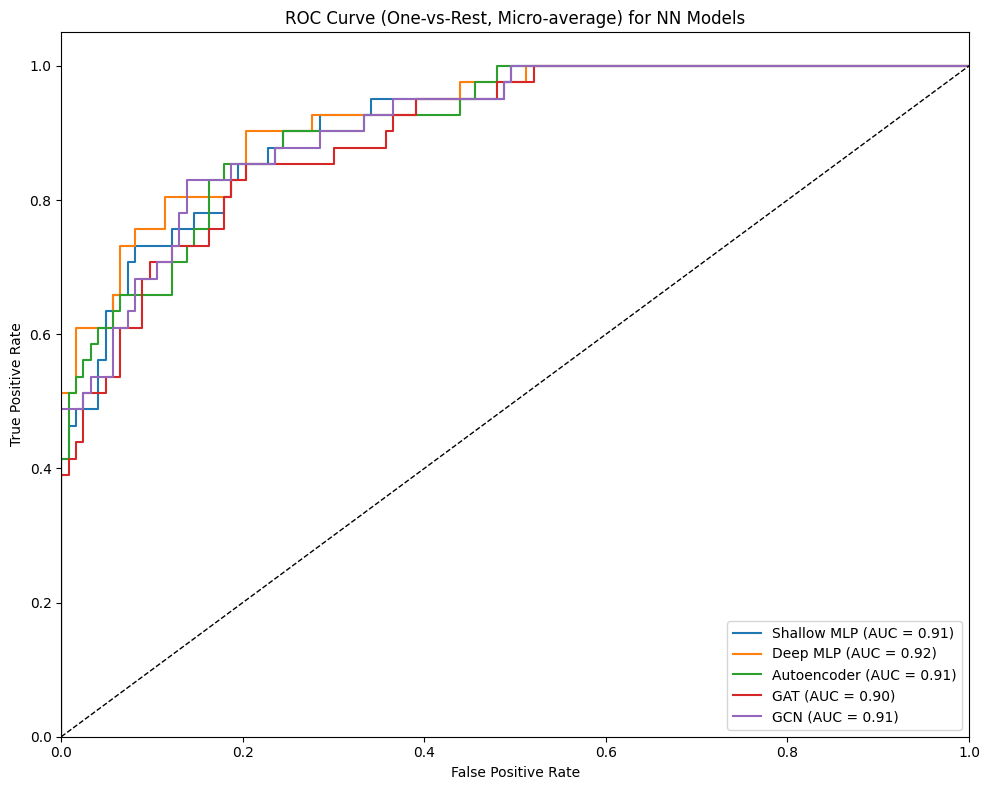

In [ ]:
# Plot ROC curves and compute AUC for all NN models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# List of NN models and their logits (before softmax) and true labels
nn_models = [
    ('Shallow MLP', logits_shallow, y_true_shallow),
    ('Deep MLP', logits_deep, y_true_deep),
    ('Autoencoder', logits_ae, y_true_ae)
 ]

plt.figure(figsize=(10, 8))
for name, logits, y_true in nn_models:
    try:
        # Convert logits to probabilities
        y_pred_proba = np.exp(logits.cpu().numpy())
        y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for NN Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()